# Comparing `nnde` and TensorFlow for `lagaris01`: scaling behavior for fixed network size (H=5, 10, ..., 50)

## Introduction

The purpose of this notebook is to provide a comparison between the `nnde` code and TensorFlow for the solution of the `lagaris01` ODE.

## The `lagaris01` problem

This ODE was used as the first example problem in (Lagaris et al., 1998). It has been used in several other papers in the neural network/differential equation literature. The differential equation is provided in the form (equation (27) in Lagaris (1998)):

\begin{equation}
    \frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi =
    x^3 + 2x + x^2 \frac {1+3x^2} {1+x+x^3}
\end{equation}

or:

\begin{equation}
    G\left(x,\psi,\frac {d\psi}{dx}\right) = \frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi - x^3 - 2x - x^2 \frac {1+3x^2} {1+x+x^3} = 0
\end{equation}

The initial condition is:

\begin{equation}
    \psi(0)=1
\end{equation}

The analytical solution is:

\begin{equation}
    \psi_a(x) = x^2 + \frac {e^{-x^2/2}} {1 + x +  x^3}
\end{equation}

The first derivative is:

\begin{equation}
    \frac {d\psi_a} {dx} = 2x - \frac {e^{-x^2/2} (1+x+4x^2+x^4)} {(1+x+x^3)^2}
\end{equation}

The analytical solution and derivative in the domain $[0,1]$ are plotted below.

In [1]:
# Import standard Python modules.
import datetime
from math import exp, sqrt
import matplotlib.pyplot as plt
import numpy as np

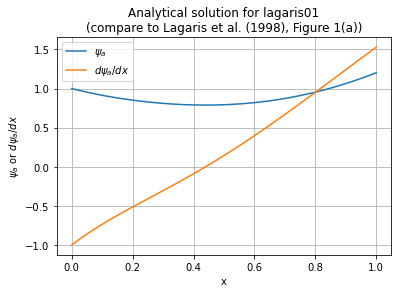

In [2]:
import nnde.differentialequation.examples.lagaris_01 as lagaris01

# Load the equation.
eq_name = "lagaris01"

# Compute the analytical solution and derivative.
na = 101
xa = np.linspace(0, 1, na)
Ya = np.zeros(na)
dYa_dx = np.zeros(na)
for i in range(na):
    Ya[i] = lagaris01.Ya(xa[i])
    dYa_dx[i] = lagaris01.dYa_dx(xa[i])

# Plot the analytical solution and derivative.
plt.plot(xa, Ya, label="$\psi_a$")
plt.plot(xa, dYa_dx, label="$d\psi_a/dx$")
plt.xlabel("x")
plt.ylabel("$\psi_a$ or $d\psi_a/dx$")
plt.grid()
plt.legend()
plt.title("Analytical solution for %s\n(compare to Lagaris et al. (1998), Figure 1(a))" %
         (eq_name));

## Shared hyperparameters

In [3]:
# Module and name for equation to solve
eq_module = "nnde.differentialequation.examples.lagaris_01"
eq_name = "lagaris01"

# Training data range
xmin = 0
xmax = 1

# Number of training points.
nt = 11

# Learning rate
learning_rate = 0.01

# Maximum number of training epochs
max_epochs = 1000

# Starting ranges for weights and biases.
b_min = -0.1
b_max = 0.1
v_min = -0.1
v_max = 0.1
w_min = -0.1
w_max = 0.1

## Solving `lagaris01` using the `nnde` package and delta optimizer

In [4]:
# Load the nnde packages needed for this problem.
from nnde.neuralnetwork.nnode1ivp import NNODE1IVP
from nnde.differentialequation.ode.ode1ivp import ODE1IVP

# Create the training data.
xt = np.linspace(xmin, xmax, nt)

# Create the ODE object for the problem.
ode = ODE1IVP(eq_module)

# Specify training options.
trainalg = "delta"
opts = {}
opts["b_min"] = b_min
opts["b_max"] = b_max
opts["v_min"] = v_min
opts["v_max"] = v_max
opts["w_min"] = w_min
opts["w_max"] = w_max

# Train the network for a series of hidden node counts.
nets = []
nnde_run_times = []
for H in range(5, 55, 5):
    print("\nStarting solution with %s hidden nodes." % (H))

    # Create the network.
    np.random.seed(0)
    net = NNODE1IVP(ode, nhid=H)
    nets.append(net)

    # Train the network.
    t_start = datetime.datetime.now()
    %timeit -n 1 -r 1 net.train(xt, trainalg=trainalg, opts=opts)
    t_stop = datetime.datetime.now()
    t_elapsed = t_stop - t_start
    print("Elapsed time (s): %s, time per iteration: %s" % (t_elapsed, t_elapsed/max_epochs))
    nnde_run_times.append(t_elapsed)


Starting solution with 5 hidden nodes.
302 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Elapsed time (s): 0:00:00.303617, time per iteration: 0:00:00.000304

Starting solution with 10 hidden nodes.
334 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Elapsed time (s): 0:00:00.334698, time per iteration: 0:00:00.000335

Starting solution with 15 hidden nodes.
371 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Elapsed time (s): 0:00:00.371689, time per iteration: 0:00:00.000372

Starting solution with 20 hidden nodes.
410 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Elapsed time (s): 0:00:00.410829, time per iteration: 0:00:00.000411

Starting solution with 25 hidden nodes.
459 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Elapsed time (s): 0:00:00.460326, time per iteration: 0:00:00.000460

Starting solution with 30 hidden nodes.
477 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Elapsed time (s): 0:00:00.

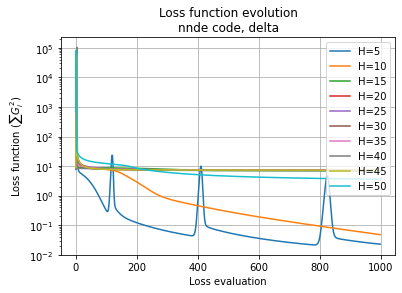

In [5]:
# Plot the loss function history for each network.
for net in nets:
    plt.semilogy(net.losses, label="H=%s" % len(net.v))

plt.title("Loss function evolution\nnnde code, %s" % (trainalg,))
plt.xlabel("Loss evaluation")
plt.ylabel("Loss function ($\sum G_i^2$)")
plt.grid()
plt.legend()
plt.show()

## Solving `lagaris01` using TensorFlow

In [21]:
import tensorflow as tf

# Convert the training data to a TensorFlow Variable.
xtv = tf.Variable(xt.reshape((nt, 1)), dtype=tf.float32)

tf_nets = []
tf_losses = []
tf_run_times = []

for H in range(5, 55, 5):
    print("\nStarting solution with %s hidden nodes." % (H))

    # Create the network.
    tf.random.set_seed(0)
    hidden_layer = tf.keras.layers.Dense(
        units=H, use_bias=True,
        activation=tf.keras.activations.sigmoid,
        kernel_initializer=tf.keras.initializers.RandomUniform(minval=w_min, maxval=w_max),
        bias_initializer=tf.keras.initializers.RandomUniform(minval=b_min, maxval=b_max)
    )
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.RandomUniform(minval=v_min, maxval=v_max),
        use_bias=False
    )
    model = tf.keras.Sequential([hidden_layer, output_layer])

    # Train the network.
    x = xtv
    losses = []
    t_start = datetime.datetime.now()
    for i in range(max_epochs):
        # Compute the forward pass for each training point.
        with tf.GradientTape(persistent=True) as tape:
            N = model(x)
            N = tf.reshape(N, (nt, 1))
            y = 1 + x*N
            dN_dx = tape.gradient(N, x)
            G = x*dN_dx + N + (x + (1 + 3*x**2)/(1 + x + x**3))*y - x**3 - 2*x - x**2*(1 + 3*x**2)/(1 + x + x**3)
            L = tf.reduce_sum(G**2)
            losses.append(L.numpy())

        # Compute the gradients.
        grad = tape.gradient(L, model.trainable_variables)

        # Update the parameters for this pass.
        for (v, d) in zip(model.trainable_variables, grad):
            v.assign_sub(learning_rate*d)

    t_stop = datetime.datetime.now()
    t_elapsed = t_stop - t_start
    print("Elapsed time (s): %s, time per iteration: %s" % (t_elapsed, t_elapsed/max_epochs))
    tf_nets.append(model)
    tf_losses.append(losses)
    tf_run_times.append(t_elapsed)


Starting solution with 5 hidden nodes.
Elapsed time (s): 0:00:03.955893, time per iteration: 0:00:00.003956

Starting solution with 10 hidden nodes.
Elapsed time (s): 0:00:03.944733, time per iteration: 0:00:00.003945

Starting solution with 15 hidden nodes.
Elapsed time (s): 0:00:04.023364, time per iteration: 0:00:00.004023

Starting solution with 20 hidden nodes.
Elapsed time (s): 0:00:03.938535, time per iteration: 0:00:00.003939

Starting solution with 25 hidden nodes.
Elapsed time (s): 0:00:03.975336, time per iteration: 0:00:00.003975

Starting solution with 30 hidden nodes.
Elapsed time (s): 0:00:04.008104, time per iteration: 0:00:00.004008

Starting solution with 35 hidden nodes.
Elapsed time (s): 0:00:04.127242, time per iteration: 0:00:00.004127

Starting solution with 40 hidden nodes.
Elapsed time (s): 0:00:04.067834, time per iteration: 0:00:00.004068

Starting solution with 45 hidden nodes.
Elapsed time (s): 0:00:03.982059, time per iteration: 0:00:00.003982

Starting s

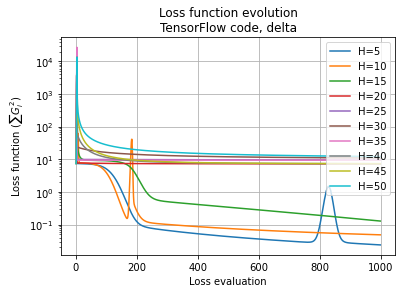

In [25]:
# Plot the loss function history for each network.
for (net, losses) in zip(tf_nets, tf_losses):
    plt.semilogy(losses, label="H=%s" % len(net.trainable_variables[-2].numpy()))

plt.title("Loss function evolution\nTensorFlow code, %s" % (trainalg,))
plt.xlabel("Loss evaluation")
plt.ylabel("Loss function ($\sum G_i^2$)")
plt.grid()
plt.legend()
plt.show()

## Run time comparison

In [40]:
sizes = list(range(5, 55, 5))
t_nnde = [t.total_seconds() for t in nnde_run_times]
t_tf = [t.total_seconds() for t in tf_run_times]

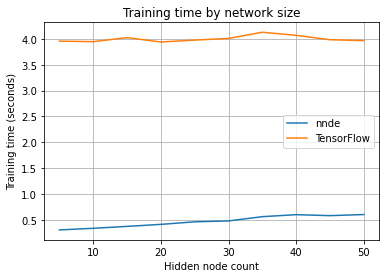

In [45]:
plt.plot(sizes, t_nnde, label="nnde")
plt.plot(sizes, t_tf, label="TensorFlow")

plt.title("Training time by network size")
plt.xlabel("Hidden node count")
plt.ylabel("Training time (seconds)")
plt.grid()
plt.legend()
plt.show()

In [42]:
sizes

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50]